#Enviroment Settings


In [8]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [9]:
ls

gdrive/  sample_data/


In [0]:
import os
os.chdir("/content/gdrive/My Drive/UIUC/2019_spring/CS544--optimizer computer vision/project")

In [11]:
ls # Check if this is your MP4 folder

 data/                             'yuxuanz6_cs544_project(1).ipynb'
 Drift_Data/                       'yuxuanz6_cs544_project(2).ipynb'
 opt_res_part1/                    'yuxuanz6_cs544_project(3).ipynb'
 opt_res_part2/                    'yuxuanz6_cs544_project(4).ipynb'
 SGD-plot.png                      'yuxuanz6_cs544_project(5-part1).ipynb'
 submission/                       'yuxuanz6_cs544_project(6).ipynb'
'yuxuanz6_cs544_project(0).ipynb'   yuxuanz6_cs544_project.ipynb


In [0]:
!mkdir /data
!cp data/cifar100.tar.gz /data/
!tar -xf /data/cifar100.tar.gz -C /data/
!cp data/test.tar.gz /data
!tar -xf /data/test.tar.gz -C /data
!cp data/train.tar.gz /data
!tar -xf /data/train.tar.gz -C /data/

In [13]:
ls /data

cifar100/  cifar100.tar.gz  test/  test.tar.gz  train/  train.tar.gz


In [14]:
!pip3 install torch torchvision

In [15]:
import torch
a = torch.Tensor([1]).cuda()
print(a)


tensor([1.], device='cuda:0')


In [16]:
torch.cuda.is_available()

True

# Part1 - BaseNet(adapt from vgg net) Optimization 

##Part1.0 - Load the CIFAR-100 Data

In [17]:
"""Headers"""

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity

import csv
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)

In [0]:
""""""

class CIFAR10_CS544(data.Dataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """
    base_folder = 'cifar100'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar100.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]

    def __init__(self, root, fold="train",
                 transform=None, target_transform=None,
                 download=False):
        
        fold = fold.lower()

        self.train = False
        self.test = False
        self.val = False

        if fold == "train":
            self.train = True
        elif fold == "test":
            self.test = True
        elif fold == "val":
            self.val = True
        else:
            raise RuntimeError("Not train-val-test")


        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform

        fpath = os.path.join(root, self.filename)
        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' Download it and extract the file again.')

        # now load the picked numpy arrays
        if self.train or self.val:
            self.train_data = []
            self.train_labels = []
            for fentry in self.train_list:
                f = fentry[0]
                file = os.path.join(self.root, self.base_folder, f)
                fo = open(file, 'rb')
                if sys.version_info[0] == 2:
                    entry = pickle.load(fo)
                else:
                    entry = pickle.load(fo, encoding='latin1')
                self.train_data.append(entry['data'])
                if 'labels' in entry:
                    self.train_labels += entry['labels']
                else:
                    self.train_labels += entry['fine_labels']
                fo.close()

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((50000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC
            
            p = np.arange(0,50000,10)
            mask_train = np.ones((50000,), dtype=bool)
            mask_train[p] = False
            mask_val = np.zeros((50000,), dtype=bool)
            mask_val[p] = True

            copy_all_data = np.array(self.train_data)
            self.val_data = np.array(copy_all_data[mask_val])
            self.train_data = np.array(copy_all_data[mask_train])
            
            copy_all_labels = np.array(self.train_labels)
            self.val_labels = np.array(copy_all_labels[mask_val])
            self.train_labels = np.array(copy_all_labels[mask_train])

        elif self.test:
            f = self.test_list[0][0]
            file = os.path.join(self.root, self.base_folder, f)
            fo = open(file, 'rb')
            if sys.version_info[0] == 2:
                entry = pickle.load(fo)
            else:
                entry = pickle.load(fo, encoding='latin1')
            self.test_data = entry['data']

            if 'labels' in entry:
                self.test_labels = entry['labels']
            else:
                self.test_labels = entry['fine_labels']
            fo.close()
            self.test_data = self.test_data.reshape((10000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        elif self.test:
            img, target = self.test_data[index], self.test_labels[index]
        elif self.val:
            img, target = self.val_data[index], self.val_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        elif self.test:
            return len(self.test_data)
        elif self.val:
            return len(self.val_data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


class CIFAR100_CS544(CIFAR10_CS544):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar100'
    filename = "cifar100.tar.gz"
    tgz_md5 = 'e68a4c763591787a0b39fe2209371f32'
    train_list = [
        ['train_cs544', '49eee854445c1e2ebe796cd93c20bb0f'],
    ]

    test_list = [
        ['test_cs544', 'd3fe9f6a9251bd443f428f896d27384f'],
    ]

##part1.1 - Define picked optimiers result array

In [0]:
optimer_train_loss_over_epochs_opts = []
optimer_val_accuracy_over_epochs_opts = []
optimer_time_cost = []

## Part1.2 - Set the Class and Epoches, optimier names

In [0]:
# ---------
EPOCHS = 20
# ---------
optimer_name = ['SGD','SGD+momentum0.9','ASGD','Adam','Adadelta_default',
                'Adagrad_default','Adamax_default','RMSprop_default','ASGD_default','Rprop_default']
IS_GPU = True
TEST_BS = 256
TOTAL_CLASSES = 100
TRAIN_BS = 32
PATH_TO_CIFAR100_CS544 = "/data/"

In [208]:
ls /data/cifar100/

test_cs544  train_cs544


## Part1.3 - Define the val accuracy function

In [0]:
def calculate_val_accuracy(valloader, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        valloader (torch.utils.data.DataLoader): val set 
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """    
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    for data in valloader:
        images, labels = data
        if is_gpu:
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(list(predicted.cpu().numpy()))
        total += labels.size(0)
        correct += (predicted == labels).sum()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy

## Part1.4 - Augument and Normalize input data

In [210]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Using transforms.ToTensor(), transform them to Tensors of normalized range
# [-1, 1].


train_transform = transforms.Compose(
    [
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
#     transforms.Normalize([0.505, 0.496, 0.446], [0.259, 0.254, 0.275])
      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
#     transforms.Normalize([0.505, 0.496, 0.446], [0.259, 0.254, 0.275])
      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

# ---------------------

trainset = CIFAR100_CS544(root=PATH_TO_CIFAR100_CS544, fold="train",
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BS,
                                          shuffle=True, num_workers=2)
print("Train set size: "+str(len(trainset)))

valset = CIFAR100_CS544(root=PATH_TO_CIFAR100_CS544, fold="val",
                                       download=True, transform=test_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=TEST_BS,
                                         shuffle=False, num_workers=2)
print("Val set size: "+str(len(valset)))

testset = CIFAR100_CS544(root=PATH_TO_CIFAR100_CS544, fold="test",
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BS,
                                         shuffle=False, num_workers=2)
print("Test set size: "+str(len(testset)))

# The 100 classes for CIFAR100
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']



Train set size: 45000
Val set size: 5000
Test set size: 10000


## Part1.5 - Define neural network layers

In [0]:
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

import torch.nn as nn
import torch.nn.functional as F

def conv2d_norm_relu(in_channel, out_channel, kernel, stride=1, padding=1):
    layer = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel, stride=1, padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(True)
    )
    return layer
  
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        

        self.conv1 = conv2d_norm_relu(3, 64, 3,  padding=1)
        self.conv2 = conv2d_norm_relu(64, 64, 3,  padding=1)
        self.conv3 = conv2d_norm_relu(64, 128, 3,  padding=1)
        self.conv4 = conv2d_norm_relu(128, 128, 3,  padding=1)
        self.conv5 = conv2d_norm_relu(128, 256, 3,  padding=1)
        self.conv6 = conv2d_norm_relu(256, 256, 3,  padding=1)
        self.conv7 = conv2d_norm_relu(256, 512, 3,  padding=1)
        self.conv8 = conv2d_norm_relu(512, 512, 3,  padding=1)
        self.pool = nn.MaxPool2d(2, 2, padding=0)


        class Flatten(torch.nn.Module):
           def forward(self, x):
            return x.view(x.size()[0], -1)
      
        self.fc_net = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 100)
        )

    def forward(self, x):
       
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x) # output: 16 x 16 x 64
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x) # output: 8 x 8 x 128
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool(x)# output: 4 x 4 x 256
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.pool(x)# output: 2 x 2 x 512
        x = x.view(-1, 2048)
#         print('view:',x.shape)
        x = self.fc_net(x)

        return x

# Create an instance of the nn.module class defined above:
net = BaseNet()

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()


## Part1.6 - Define loss function and optimizers

In [0]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum is useful or not
# optimizer = optim.SGD(net.parameters(),lr=1e-3)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.ASGD(net.parameters(),  lr=1e-3) # remove the alpha
# optimizer = optim.Adam(net.parameters(), lr=1e-3)
# optimizer = optim.Adadelta(net.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0) # default
# optimizer = optim.Adagrad(net.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0) # default
# optimizer = optim.Adamax(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0) # default
# optimizer = optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False) # default
# optimizer = optim.ASGD(net.parameters(), lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0) # default
optimizer = optim.Rprop(net.parameters(), lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-06, 50)) # default

timer  = []
train_loss_over_epochs = []
val_accuracy_over_epochs = []
plt.ioff()
fig = plt.figure()


##Part1.7- Train, Validation


In [0]:
import time

In [214]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    start = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    # Normalizing the loss by the total number of train batches
    running_loss/=len(trainloader)
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_val_accuracy(valloader, IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    # # Optionally print classwise accuracies
    # for c_i in range(TOTAL_CLASSES):
    #     print('Accuracy of %5s : %2d %%' % (
    #         classes[c_i], 100 * val_classwise_accuracy[c_i]))
    end = time.time()
    ti = end - start
    timer.append(ti)
    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy)

# -----------------------------

[1] loss: 271.317
Accuracy of the network on the val images: 1 %
[2] loss: 371.431
Accuracy of the network on the val images: 1 %
[3] loss: 353.140
Accuracy of the network on the val images: 1 %
[4] loss: 329.056
Accuracy of the network on the val images: 1 %
[5] loss: 336.361
Accuracy of the network on the val images: 1 %
[6] loss: 330.920
Accuracy of the network on the val images: 1 %
[7] loss: 357.755
Accuracy of the network on the val images: 1 %
[8] loss: 352.342
Accuracy of the network on the val images: 1 %
[9] loss: 327.984
Accuracy of the network on the val images: 1 %
[10] loss: 323.862
Accuracy of the network on the val images: 1 %
[11] loss: 318.324
Accuracy of the network on the val images: 1 %
[12] loss: 349.535
Accuracy of the network on the val images: 1 %
[13] loss: 368.678
Accuracy of the network on the val images: 1 %
[14] loss: 354.838
Accuracy of the network on the val images: 1 %
[15] loss: 352.203
Accuracy of the network on the val images: 1 %
[16] loss: 345.508


##part1.8 - Visualizing single optimier prediction result

In [215]:
# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(3, 1, 1)
plt.ylabel('time sec')
plt.plot(np.arange(EPOCHS), timer, 'g-')
plt.title(str(optimer_name[9]) + ' train time,loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(3, 1, 2)
plt.ylabel('train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig(str(optimer_name[9])+"_plot.png")
plt.close(fig)
print(str(optimer_name[9]) + ' finished training')
# -------------

Rprop_default finished training


In [216]:
print("train_loss_over_epochs_opts =  ", train_loss_over_epochs)
print("val_accuracy_over_epochs_opts = ", val_accuracy_over_epochs)
print("time_cost = ", timer)
if(len(train_loss_over_epochs) == 20 and 
   len(val_accuracy_over_epochs) == 20 and 
   len(timer) == 20):
#      optimer_train_loss_over_epochs_opts[0] = train_loss_over_epochs
#      optimer_val_accuracy_over_epochs_opts[0] = val_accuracy_over_epochs
#      optimer_time_cost[0] = timer
   optimer_train_loss_over_epochs_opts.append(train_loss_over_epochs)
   optimer_val_accuracy_over_epochs_opts.append(val_accuracy_over_epochs)
   optimer_time_cost.append(timer)
   t = np.arange(0, EPOCHS, 1) # equals epoch number
   print(len(train_loss_over_epochs),len(val_accuracy_over_epochs),len(timer),len(t))
   print(len(optimer_train_loss_over_epochs_opts),len(optimer_val_accuracy_over_epochs_opts),len(optimer_time_cost))  

train_loss_over_epochs_opts =   [271.31657391909425, 371.43133382926027, 353.1397174162143, 329.05570190581517, 336.3613701042929, 330.91973510801836, 357.75530001688446, 352.3423848074213, 327.9842632482809, 323.86208351741215, 318.32446430520804, 349.53548696385093, 368.67753887040953, 354.8382604015407, 352.20267777148086, 345.50844106220063, 352.8695552150832, 413.67957622579587, 418.7772423992279, 445.7545087261241]
val_accuracy_over_epochs_opts =  [tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0,

##part1.9 - Visualizing picked optimiers prediction result

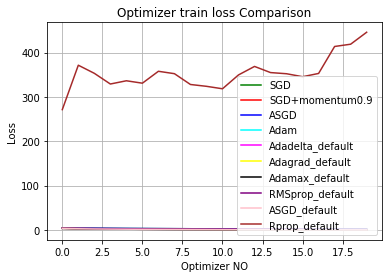

In [251]:
if(len(optimer_train_loss_over_epochs_opts) == 10 and 
   len(optimer_val_accuracy_over_epochs_opts) == 10 and 
   len(optimer_time_cost) == 10):
   plt.title('Optimizer train loss Comparison')
   plt.ylabel('Loss')  
   plt.xlabel('Optimizer NO') 
   plt.plot(t,optimer_train_loss_over_epochs_opts[0],label=str(optimer_name[0]),color='green')
   plt.plot(t,optimer_train_loss_over_epochs_opts[1],label=str(optimer_name[1]),color='red')
   plt.plot(t,optimer_train_loss_over_epochs_opts[2],label=str(optimer_name[2]),color='blue')
   plt.plot(t,optimer_train_loss_over_epochs_opts[3],label=str(optimer_name[3]),color='cyan')
   plt.plot(t,optimer_train_loss_over_epochs_opts[4],label=str(optimer_name[4]),color='magenta')
   plt.plot(t,optimer_train_loss_over_epochs_opts[5],label=str(optimer_name[5]),color='yellow')
   plt.plot(t,optimer_train_loss_over_epochs_opts[6],label=str(optimer_name[6]),color='black')
   plt.plot(t,optimer_train_loss_over_epochs_opts[7],label=str(optimer_name[7]),color='purple')
   plt.plot(t,optimer_train_loss_over_epochs_opts[8],label=str(optimer_name[8]),color='pink')
#    plt.plot(t,optimer_train_loss_over_epochs_opts[9],label=str(optimer_name[9]),color='brown')         
   plt.grid(True) 
   plt.legend([str(optimer_name[0]),str(optimer_name[1]),str(optimer_name[2]),str(optimer_name[3]),
              str(optimer_name[4]),str(optimer_name[5]),str(optimer_name[6]),str(optimer_name[7]),
              str(optimer_name[8])], loc='lower right') 
   plt.show() 

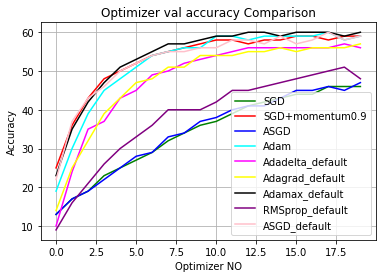

In [238]:
if(len(optimer_train_loss_over_epochs_opts) == 10 and 
   len(optimer_val_accuracy_over_epochs_opts) == 10 and 
   len(optimer_time_cost) == 10):
   plt.title('Optimizer val accuracy Comparison')
   plt.ylabel('Accuracy')  
   plt.xlabel('Optimizer NO') 
   plt.plot(t,optimer_val_accuracy_over_epochs_opts[0],label=str(optimer_name[0]),color='green')
   plt.plot(t,optimer_val_accuracy_over_epochs_opts[1],label=str(optimer_name[1]),color='red')
   plt.plot(t,optimer_val_accuracy_over_epochs_opts[2],label=str(optimer_name[2]),color='blue')
   plt.plot(t,optimer_val_accuracy_over_epochs_opts[3],label=str(optimer_name[3]),color='cyan')
   plt.plot(t,optimer_val_accuracy_over_epochs_opts[4],label=str(optimer_name[4]),color='magenta')
   plt.plot(t,optimer_val_accuracy_over_epochs_opts[5],label=str(optimer_name[5]),color='yellow')
   plt.plot(t,optimer_val_accuracy_over_epochs_opts[6],label=str(optimer_name[6]),color='black')
   plt.plot(t,optimer_val_accuracy_over_epochs_opts[7],label=str(optimer_name[7]),color='purple')
   plt.plot(t,optimer_val_accuracy_over_epochs_opts[8],label=str(optimer_name[8]),color='pink')
#    plt.plot(t,optimer_val_accuracy_over_epochs_opts[9],label=str(optimer_name[9]),color='brown')         
   plt.grid(True) 
   plt.legend([str(optimer_name[0]),str(optimer_name[1]),str(optimer_name[2]),str(optimer_name[3]),
              str(optimer_name[4]),str(optimer_name[5]),str(optimer_name[6]),str(optimer_name[7]),
              str(optimer_name[8])], loc='lower right') 
   plt.show()

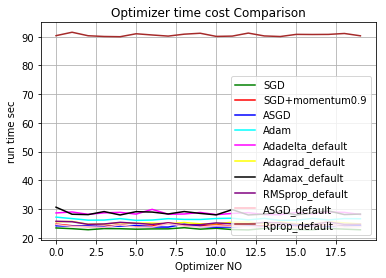

In [250]:
if(len(optimer_train_loss_over_epochs_opts) == 10 and 
   len(optimer_val_accuracy_over_epochs_opts) == 10 and 
   len(optimer_time_cost) == 10):
   plt.title('Optimizer time cost Comparison')
   plt.ylabel('run time sec')  
   plt.xlabel('Optimizer NO') 
   plt.plot(t,optimer_time_cost[0],label=str(optimer_name[0]),color='green')
   plt.plot(t,optimer_time_cost[1],label=str(optimer_name[1]),color='red')
   plt.plot(t,optimer_time_cost[2],label=str(optimer_name[2]),color='blue')
   plt.plot(t,optimer_time_cost[3],label=str(optimer_name[3]),color='cyan')
   plt.plot(t,optimer_time_cost[4],label=str(optimer_name[4]),color='magenta')
   plt.plot(t,optimer_time_cost[5],label=str(optimer_name[5]),color='yellow')
   plt.plot(t,optimer_time_cost[6],label=str(optimer_name[6]),color='black')
   plt.plot(t,optimer_time_cost[7],label=str(optimer_name[7]),color='purple')
   plt.plot(t,optimer_time_cost[8],label=str(optimer_name[8]),color='pink')
#    plt.plot(t,optimer_time_cost[9],label=str(optimer_name[9]),color='brown')         
   plt.grid(True) 
   plt.legend([str(optimer_name[0]),str(optimer_name[1]),str(optimer_name[2]),str(optimer_name[3]),
              str(optimer_name[4]),str(optimer_name[5]),str(optimer_name[6]),str(optimer_name[7]),
              str(optimer_name[8])], loc='lower right') 
   plt.show()

# Part 2 - ResNet Model Optimization

##part2.0 - Define picked optimiers result array

In [0]:
optimer_train_loss_over_epochs_opts2 = []
optimer_train_accuracy_over_epochs_opts2 = []
optimer_time_cost2 = []
optimizer_test_loss = []
optimizer_test_accuracy = []
optimizer_time_cost3  = []

In [0]:
optimer_name2 = ['SGD','SGD+momentum0.9','ASGD','Adam','Adadelta_default',
                'Adagrad_default','Adamax_default','RMSprop_default','ASGD_default','Rprop_default']

## Part 2.1 - Load the pre-trained resnet model

In [0]:
"""Headers"""
import os
import os.path as osp
import time

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms

In [0]:
class PreTrainedResNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedResNet, self).__init__()
    
    self.resnet18 = models.resnet18(pretrained=True)
#     self.resnet152 = models.resnet152(pretrained=True) # will run out of memory
#     self.resnet101 = models.resnet101(pretrained=True) # will run out of memory
#     self.resnet50 = models.resnet50(pretrained=True)
#     self.inception = models.inception_v3(pretrained=True) # softmax problem
    #Set gradients to false
    if feature_extracting:
      for param in self.resnet18.parameters():
          param.requires_grad = False
    
    #Replace last fc layer
    num_feats = self.resnet18.fc.in_features
    self.resnet18.fc = nn.Linear(num_feats, 200)
    
  def forward(self, x):
    x = self.resnet18(x)
    return x

## Part 2.2 - Define train function

In [0]:
def train(model, optimizer, criterion, epoch, num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_acc = 0.0
  
  for batch_idx, (images, labels) in enumerate(dataloaders['train']):
    #zero the parameter gradients
    optimizer.zero_grad()
    
    #move to GPU
    images, labels = images.cuda(), labels.cuda()
    
    #forward
    outputs = model.forward(images)
    
    loss = criterion(outputs, labels)
    
    _, preds = torch.max(outputs.data, 1)
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += torch.sum(preds == labels).item()
    
  epoch_loss /= dataset_sizes['train']
  epoch_acc /= dataset_sizes['train']
  
  print('TRAINING Epoch %d/%d Loss %.4f Accuracy %.4f' % (epoch, num_epochs, epoch_loss, epoch_acc))
  return epoch_loss,epoch_acc

## Part 2.3 - Define main function
1. Vary hyperparams
2. Data augmentation

In [0]:
NUM_EPOCHS = 40
LEARNING_RATE = 0.01 # 
BATCH_SIZE = 80
RESNET_LAST_ONLY = False #Fine tunes only the last layer. Set to False to fine tune entire network

root_path = '/data/'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
#       transforms.CenterCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

#Initialize the model
model = PreTrainedResNet(len(class_names), RESNET_LAST_ONLY)
model = model.cuda()

## Part 2.4 - Define loss function and optimiers

In [0]:
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9) -- part 2 default setting
criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
# optimizer = optim.ASGD(model.parameters(),  lr=LEARNING_RATE) # remove the alpha
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0) # default
# optimizer = optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0) # default
# optimizer = optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0) # default
# optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False) # default
# optimizer = optim.ASGD(model.parameters(), lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0) # default
optimizer = optim.Rprop(model.parameters(), lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-06, 50)) # default


timer2  = []
train_loss_over_epochs2 = []
train_accuracy_over_epochs2 = []
plt.ioff()
fig = plt.figure()

## Part 2.5 - train the model

In [205]:
#Begin Train
for epoch in range(NUM_EPOCHS):
  start = time.time()
  train_epoch_loss,train_epoch_acc = train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  end = time.time()
  ti = end - start
  timer2.append(ti)
  train_loss_over_epochs2.append(train_epoch_loss)
  train_accuracy_over_epochs2.append(train_epoch_acc)
print("Finished Training")
print("-"*10)

optimer_train_loss_over_epochs_opts2.append(train_loss_over_epochs2)
optimer_train_accuracy_over_epochs_opts2.append(train_accuracy_over_epochs2)
optimer_time_cost2.append(timer2)

TRAINING Epoch 1/40 Loss 0.0919 Accuracy 0.0030
TRAINING Epoch 2/40 Loss 0.0784 Accuracy 0.0093
TRAINING Epoch 3/40 Loss 0.1210 Accuracy 0.0090
TRAINING Epoch 4/40 Loss 0.1626 Accuracy 0.0093
TRAINING Epoch 5/40 Loss 0.2677 Accuracy 0.0083
TRAINING Epoch 6/40 Loss 0.2011 Accuracy 0.0090
TRAINING Epoch 7/40 Loss 0.3129 Accuracy 0.0050
TRAINING Epoch 8/40 Loss 0.3288 Accuracy 0.0077
TRAINING Epoch 9/40 Loss 0.3664 Accuracy 0.0073
TRAINING Epoch 10/40 Loss 1.1886 Accuracy 0.0050
TRAINING Epoch 11/40 Loss 1.0636 Accuracy 0.0073
TRAINING Epoch 12/40 Loss 2.1457 Accuracy 0.0083
TRAINING Epoch 13/40 Loss 2.4675 Accuracy 0.0063
TRAINING Epoch 14/40 Loss 4.0406 Accuracy 0.0097
TRAINING Epoch 15/40 Loss 3.7310 Accuracy 0.0090
TRAINING Epoch 16/40 Loss 4.8876 Accuracy 0.0090
TRAINING Epoch 17/40 Loss 4.1615 Accuracy 0.0117
TRAINING Epoch 18/40 Loss 4.8271 Accuracy 0.0100
TRAINING Epoch 19/40 Loss 6.1380 Accuracy 0.0047
TRAINING Epoch 20/40 Loss 5.9884 Accuracy 0.0067
TRAINING Epoch 21/40 Loss 6.4

## Part 2.6 - Visualizing single optimizer train prediction result

In [206]:
# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
print(NUM_EPOCHS,len(timer2))
plt.subplot(3, 1, 1)
plt.ylabel('time sec')
plt.plot(np.arange(NUM_EPOCHS), timer2, 'g-')
plt.title(str(optimer_name2[9]) + ' train time,loss and accuracy')
plt.xticks(np.arange(NUM_EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(3, 1, 2)
plt.ylabel('train loss')
plt.plot(np.arange(NUM_EPOCHS), train_loss_over_epochs2, 'k-')
plt.xticks(np.arange(NUM_EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(np.arange(NUM_EPOCHS), train_accuracy_over_epochs2, 'b-')
plt.ylabel('train accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(NUM_EPOCHS, dtype=int))
plt.grid(True)
plt.savefig('opt_res_part2/' + str(optimer_name2[9])+"-plot.png")
plt.close(fig)
print(str(optimer_name2[9]) + ' finished training')
# -------------
print(len(optimer_train_loss_over_epochs_opts2),len(optimer_train_accuracy_over_epochs_opts2),len(optimer_time_cost2))

40 40
Rprop_default finished training
10 10 10


## Part 2.7 - Visualizing total optimizers train prediction result

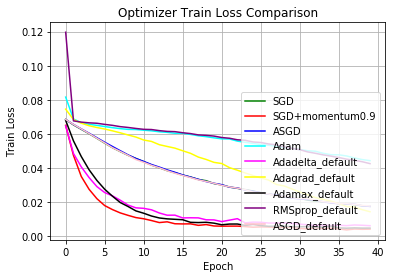

In [218]:
if(len(optimer_train_loss_over_epochs_opts2) == 10 and 
   len(optimer_train_accuracy_over_epochs_opts2) == 10 and 
   len(optimer_time_cost2) == 10):
   t = np.arange(0, NUM_EPOCHS, 1) # equals epoch number
   plt.title('Optimizer Train Loss Comparison')
   plt.ylabel('Train Loss')  
   plt.xlabel('Epoch') 
   plt.plot(t,optimer_train_loss_over_epochs_opts2[0],label=str(optimer_name2[0]),color='green')
   plt.plot(t,optimer_train_loss_over_epochs_opts2[1],label=str(optimer_name2[1]),color='red')
   plt.plot(t,optimer_train_loss_over_epochs_opts2[2],label=str(optimer_name2[2]),color='blue')
   plt.plot(t,optimer_train_loss_over_epochs_opts2[3],label=str(optimer_name2[3]),color='cyan')
   plt.plot(t,optimer_train_loss_over_epochs_opts2[4],label=str(optimer_name2[4]),color='magenta')
   plt.plot(t,optimer_train_loss_over_epochs_opts2[5],label=str(optimer_name2[5]),color='yellow')
   plt.plot(t,optimer_train_loss_over_epochs_opts2[6],label=str(optimer_name2[6]),color='black')
   plt.plot(t,optimer_train_loss_over_epochs_opts2[7],label=str(optimer_name2[7]),color='purple')
   plt.plot(t,optimer_train_loss_over_epochs_opts2[8],label=str(optimer_name2[8]),color='pink')
#    plt.plot(t,optimer_train_loss_over_epochs_opts2[9],label=str(optimer_name2[9]),color='brown')         
   plt.grid(True) 
   plt.legend([str(optimer_name2[0]),str(optimer_name2[1]),str(optimer_name2[2]),str(optimer_name2[3]),
              str(optimer_name2[4]),str(optimer_name2[5]),str(optimer_name2[6]),str(optimer_name2[7]),
              str(optimer_name2[8])], loc='lower right') 
   plt.show() 

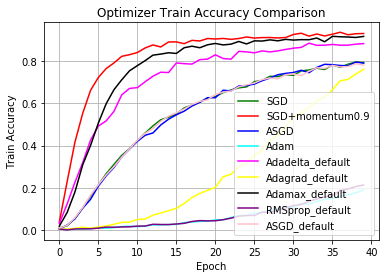

In [240]:
if(len(optimer_train_loss_over_epochs_opts2) == 10 and 
   len(optimer_train_accuracy_over_epochs_opts2) == 10 and 
   len(optimer_time_cost2) == 10):
   t = np.arange(0, NUM_EPOCHS, 1) # equals epoch number
   plt.title('Optimizer Train Accuracy Comparison')
   plt.ylabel('Train Accuracy')  
   plt.xlabel('Epoch') 
   plt.plot(t,optimer_train_accuracy_over_epochs_opts2[0],label=str(optimer_name2[0]),color='green')
   plt.plot(t,optimer_train_accuracy_over_epochs_opts2[1],label=str(optimer_name2[1]),color='red')
   plt.plot(t,optimer_train_accuracy_over_epochs_opts2[2],label=str(optimer_name2[2]),color='blue')
   plt.plot(t,optimer_train_accuracy_over_epochs_opts2[3],label=str(optimer_name2[3]),color='cyan')
   plt.plot(t,optimer_train_accuracy_over_epochs_opts2[4],label=str(optimer_name2[4]),color='magenta')
   plt.plot(t,optimer_train_accuracy_over_epochs_opts2[5],label=str(optimer_name2[5]),color='yellow')
   plt.plot(t,optimer_train_accuracy_over_epochs_opts2[6],label=str(optimer_name2[6]),color='black')
   plt.plot(t,optimer_train_accuracy_over_epochs_opts2[7],label=str(optimer_name2[7]),color='purple')
   plt.plot(t,optimer_train_accuracy_over_epochs_opts2[8],label=str(optimer_name2[8]),color='pink')
  # plt.plot(t,optimer_train_accuracy_over_epochs_opts2[9],label=str(optimer_name2[9]),color='brown')         
   plt.grid(True) 
   plt.legend([str(optimer_name2[0]),str(optimer_name2[1]),str(optimer_name2[2]),str(optimer_name2[3]),
              str(optimer_name2[4]),str(optimer_name2[5]),str(optimer_name2[6]),str(optimer_name2[7]),
              str(optimer_name2[8])], loc='lower right') 
   plt.show() 

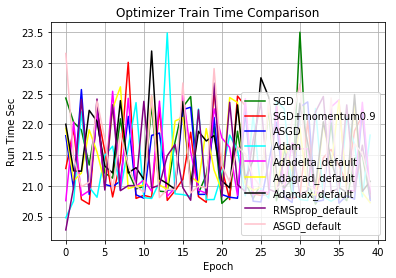

In [244]:
if(len(optimer_train_loss_over_epochs_opts2) == 10 and 
   len(optimer_train_accuracy_over_epochs_opts2) == 10 and 
   len(optimer_time_cost2) == 10):
   t = np.arange(0, NUM_EPOCHS, 1) # equals epoch number
   plt.title('Optimizer Train Time Comparison')
   plt.ylabel('Run Time Sec')  
   plt.xlabel('Epoch') 
   plt.plot(t,optimer_time_cost2[0],label=str(optimer_name2[0]),color='green')
   plt.plot(t,optimer_time_cost2[1],label=str(optimer_name2[1]),color='red')
   plt.plot(t,optimer_time_cost2[2],label=str(optimer_name2[2]),color='blue')
   plt.plot(t,optimer_time_cost2[3],label=str(optimer_name2[3]),color='cyan')
   plt.plot(t,optimer_time_cost2[4],label=str(optimer_name2[4]),color='magenta')
   plt.plot(t,optimer_time_cost2[5],label=str(optimer_name2[5]),color='yellow')
   plt.plot(t,optimer_time_cost2[6],label=str(optimer_name2[6]),color='black')
   plt.plot(t,optimer_time_cost2[7],label=str(optimer_name2[7]),color='purple')
   plt.plot(t,optimer_time_cost2[8],label=str(optimer_name2[8]),color='pink')
 #  plt.plot(t,optimer_time_cost2[9],label=str(optimer_name2[9]),color='brown')         
   plt.grid(True) 
   plt.legend([str(optimer_name2[0]),str(optimer_name2[1]),str(optimer_name2[2]),str(optimer_name2[3]),
              str(optimer_name2[4]),str(optimer_name2[5]),str(optimer_name2[6]),str(optimer_name2[7]),
              str(optimer_name2[8])], loc='lower right') 
   plt.show() 

22.42923069000244
22.03575849533081
21.90809464454651
21.33849549293518
22.12070894241333
21.207977056503296
21.12524652481079
22.091578722000122
21.231019020080566
20.94936752319336
20.988755226135254
22.303212881088257
20.912145853042603
20.901576042175293
21.715555667877197
22.2813458442688
22.454292058944702
20.88107180595398
21.178807735443115
21.97369122505188
20.71423649787903
20.834086894989014
21.88960337638855
21.055163860321045
20.789132595062256
21.03568172454834
22.253254175186157
20.757803678512573
21.624095916748047
20.846429109573364
23.50133728981018
21.080498695373535
20.702409505844116
20.92083191871643
22.024969577789307
20.883948802947998
20.7589910030365
21.449717044830322
21.496236085891724
20.78956699371338
21.28217053413391
21.924538373947144
20.776846170425415
20.700535774230957
22.22884750366211
21.56350564956665
20.81874656677246
21.394007921218872
23.011247873306274
20.795247554779053
20.84532332420349
20.812267780303955
22.275070190429688
20.76284217834472

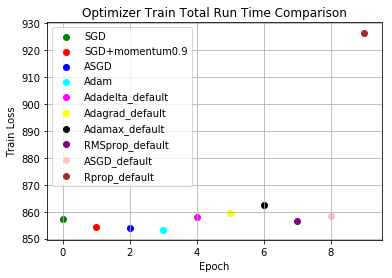

In [250]:
if(len(optimer_train_loss_over_epochs_opts2) == 10 and 
   len(optimer_train_accuracy_over_epochs_opts2) == 10 and 
   len(optimer_time_cost2) == 10):
   optimer_total_time_cost2 = [] 
   for i in range(10):
      total = 0
      for j in range (NUM_EPOCHS):
          print(optimer_time_cost2[i][j])
          total += optimer_time_cost2[i][j]
      optimer_total_time_cost2.append(total) 
   plt.title('Optimizer Train Total Run Time Comparison')
   plt.ylabel('Train Loss')  
   plt.xlabel('Epoch') 
   plt.scatter(0,optimer_total_time_cost2[0],label=str(optimer_name2[0]),color='green')
   plt.scatter(1,optimer_total_time_cost2[1],label=str(optimer_name2[1]),color='red')
   plt.scatter(2,optimer_total_time_cost2[2],label=str(optimer_name2[2]),color='blue')
   plt.scatter(3,optimer_total_time_cost2[3],label=str(optimer_name2[3]),color='cyan')
   plt.scatter(4,optimer_total_time_cost2[4],label=str(optimer_name2[4]),color='magenta')
   plt.scatter(5,optimer_total_time_cost2[5],label=str(optimer_name2[5]),color='yellow')
   plt.scatter(6,optimer_total_time_cost2[6],label=str(optimer_name2[6]),color='black')
   plt.scatter(7,optimer_total_time_cost2[7],label=str(optimer_name2[7]),color='purple')
   plt.scatter(8,optimer_total_time_cost2[8],label=str(optimer_name2[8]),color='pink')
   plt.scatter(9,optimer_total_time_cost2[9],label=str(optimer_name2[9]),color='brown')         
   plt.grid(True) 
   plt.legend([str(optimer_name2[0]),str(optimer_name2[1]),str(optimer_name2[2]),str(optimer_name2[3]),
              str(optimer_name2[4]),str(optimer_name2[5]),str(optimer_name2[6]),str(optimer_name2[7]),
              str(optimer_name2[8]),str(optimer_name2[9])], loc=2) 
   plt.show() 

## Part 2.8 - test the model

In [0]:
def test(model, criterion, repeats=2):
  
  test_loss = 0.0
  test_acc = 0.0
  
  start = time
  for itr in range(repeats):
    for batch_idx, (images, labels) in enumerate(dataloaders['train']):
      #move to GPU
      images, labels = images.cuda(), labels.cuda()

      #forward
      outputs = model.forward(images)

      loss = criterion(outputs, labels)

      _, preds = torch.max(outputs.data, 1)

      test_loss += loss.item()
      test_acc += torch.sum(preds == labels).item()
    
  test_loss /= (dataset_sizes['test']*repeats)
  test_acc /= (dataset_sizes['test']*repeats)

  print('Test Loss: %.4f Test Accuracy %.4f' % (test_loss, test_acc))
  return test_loss, test_acc

In [212]:
start = time.time()
test_loss, test_acc = test(model, criterion)
end = time.time()
test_timer = end - start
optimizer_test_loss.append(test_loss)
optimizer_test_accuracy.append(test_acc)
optimizer_time_cost3.append(test_timer)
print(len(optimizer_test_loss),len(optimizer_test_accuracy),len(optimizer_time_cost3))

Test Loss: 4.7098 Test Accuracy 0.0073
10 10 10


## Part 2.9 - Visualizing total optimizers test prediction result

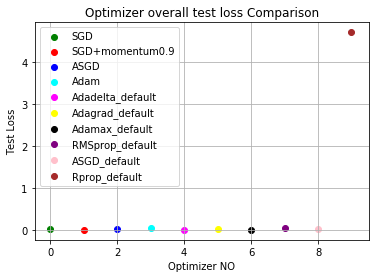

In [223]:
if(len(optimizer_test_loss) == 10 and 
   len(optimizer_test_accuracy) == 10 and 
   len(optimizer_time_cost3) == 10):
   plt.title('Optimizer overall test loss Comparison')
   plt.ylabel('Test Loss')  
   plt.xlabel('Optimizer NO') 
   plt.scatter(0,optimizer_test_loss[0],color='green')
   plt.scatter(1,optimizer_test_loss[1],color='red')
   plt.scatter(2,optimizer_test_loss[2],color='blue')
   plt.scatter(3,optimizer_test_loss[3],color='cyan')
   plt.scatter(4,optimizer_test_loss[4],color='magenta')
   plt.scatter(5,optimizer_test_loss[5],color='yellow')
   plt.scatter(6,optimizer_test_loss[6],color='black')
   plt.scatter(7,optimizer_test_loss[7],color='purple')
   plt.scatter(8,optimizer_test_loss[8],color='pink')
   plt.scatter(9,optimizer_test_loss[9],color='brown')         
   plt.grid(True) 
   plt.legend([str(optimer_name2[0]),str(optimer_name2[1]),str(optimer_name2[2]),str(optimer_name2[3]),
              str(optimer_name2[4]),str(optimer_name2[5]),str(optimer_name2[6]),str(optimer_name2[7]),
              str(optimer_name2[8]),str(optimer_name2[9])], loc=2) 
   plt.show() 

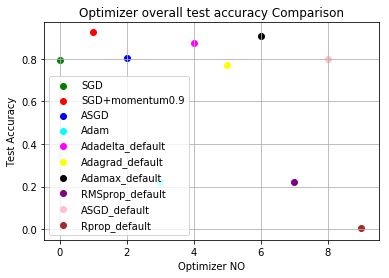

In [230]:
if(len(optimizer_test_loss) == 10 and 
   len(optimizer_test_accuracy) == 10 and 
   len(optimizer_time_cost3) == 10):
   plt.title('Optimizer overall test accuracy Comparison')
   plt.ylabel('Test Accuracy')  
   plt.xlabel('Optimizer NO') 
   plt.scatter(0,optimizer_test_accuracy[0],color='green')
   plt.scatter(1,optimizer_test_accuracy[1],color='red')
   plt.scatter(2,optimizer_test_accuracy[2],color='blue')
   plt.scatter(3,optimizer_test_accuracy[3],color='cyan')
   plt.scatter(4,optimizer_test_accuracy[4],color='magenta')
   plt.scatter(5,optimizer_test_accuracy[5],color='yellow')
   plt.scatter(6,optimizer_test_accuracy[6],color='black')
   plt.scatter(7,optimizer_test_accuracy[7],color='purple')
   plt.scatter(8,optimizer_test_accuracy[8],color='pink')
   plt.scatter(9,optimizer_test_accuracy[9],color='brown')         
   plt.grid(True) 
   plt.legend([str(optimer_name2[0]),str(optimer_name2[1]),str(optimer_name2[2]),str(optimer_name2[3]),
              str(optimer_name2[4]),str(optimer_name2[5]),str(optimer_name2[6]),str(optimer_name2[7]),
              str(optimer_name2[8]),str(optimer_name2[9])], loc=3) 
   plt.show() 

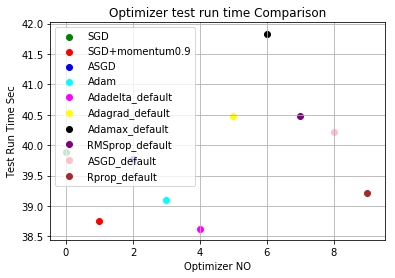

In [237]:
if(len(optimizer_test_loss) == 10 and 
   len(optimizer_test_accuracy) == 10 and 
   len(optimizer_time_cost3) == 10):
   plt.title('Optimizer test run time Comparison')
   plt.ylabel('Test Run Time Sec')  
   plt.xlabel('Optimizer NO') 
   plt.scatter(0,optimizer_time_cost3[0],label= str(optimer_name2[0]),color='green')
   plt.scatter(1,optimizer_time_cost3[1],color='red')
   plt.scatter(2,optimizer_time_cost3[2],color='blue')
   plt.scatter(3,optimizer_time_cost3[3],color='cyan')
   plt.scatter(4,optimizer_time_cost3[4],color='magenta')
   plt.scatter(5,optimizer_time_cost3[5],color='yellow')
   plt.scatter(6,optimizer_time_cost3[6],color='black')
   plt.scatter(7,optimizer_time_cost3[7],color='purple')
   plt.scatter(8,optimizer_time_cost3[8],color='pink')
   plt.scatter(9,optimizer_time_cost3[9],color='brown')           
   plt.grid(True) 
   plt.legend([str(optimer_name2[0]),str(optimer_name2[1]),str(optimer_name2[2]),str(optimer_name2[3]),
              str(optimer_name2[4]),str(optimer_name2[5]),str(optimer_name2[6]),str(optimer_name2[7]),
              str(optimer_name2[8]),str(optimer_name2[9])], loc=0) 
   plt.show() 

## Part 2.10 - Visualizing the model image predictions

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images)
        
        _, preds = torch.max(outputs.data, 1)
       

        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))

            imshow(images.cpu().data[j])

            if images_so_far == num_images:
                return

In [0]:
visualize_model(model)